In [1]:
library(tidyverse)
library(ggplot2)
library(kableExtra)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caTools)
install.packages("e1071")
library(e1071)
churn <- read_csv("../_build/data/churn_train.csv")
cvConditions <- trainControl(method = "cv", number = 5)


housing <- read_csv("../_build/data/housing_train.csv") %>% select(-Neighborhood, -Id)
levels <- c("AllPub", "NoSeWa")
housing$Utilities <- parse_factor(housing$Utilities, levels = levels)
set.seed(972943)
split <- sample.split(housing, SplitRatio = 0.8)
housing <- subset(housing, split == TRUE)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Warning message:
"package 'kableExtra' was built under R version 3.6.3"


Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



randomForest 4.6-14


Type rfNews() to see new features/changes/bug fixes.



Attaching package: 'randomForest'



The following object is masked from 'package:dplyr':

    combine



The following object is masked from 'package:ggplot2':

    margin



Warning message:
"package 'caTools' was built under R version 3.6.3"


  There is a binary version available but the source version is later:
      binary source needs_compilation
e1071  1.7-6  1.7-9              TRUE

  Binaries will be installed
package 'e1071' successfully unpacked and MD5 sums checked



The downloaded binary packages are in
	C:\Users\phamilton\AppData\Local\Temp\Rtmp6ZBlBW\downloaded_packages


Warning message:
"package 'e1071' was built under R version 3.6.3"

Parsed with column specification:
cols(
  account_length = col_double(),
  international_plan = col_character(),
  voice_mail_plan = col_character(),
  number_vmail_messages = col_double(),
  total_day_minutes = col_double(),
  total_day_calls = col_double(),
  total_night_minutes = col_double(),
  total_night_calls = col_double(),
  total_intl_minutes = col_double(),
  total_intl_calls = col_double(),
  total_intl_charge = col_double(),
  number_customer_service_calls = col_double(),
  churn = col_character()
)


Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_double(),
  MSSubClass = col_double(),
  LotFrontage = col_double(),
  LotArea = col_double(),
  OverallQual = col_double(),
  OverallCond = col_double(),
  YearBuilt = col_double(),
  YearRemodAdd = col_double(),
  MasVnrArea = col_double(),
  BsmtFinSF1 = col_double(),
  BsmtFinSF2 = col_double(),
  BsmtUnfSF = col_double(),
  TotalBsmtSF = col_double(),
  `1stFlrSF` = col_double(),
  `2ndFlrSF` = col_double(),
  LowQualFinSF = col_double(),
  GrLivArea = col_double(),
  BsmtFullBath = col_double(),
  BsmtHalfBath = col_double(),
  FullBath = col_double()
  # ... with 18 more columns
)


See spec(...) for full column specifications.


Warning message:
"Length of logical index must be 1 or 1460, not 79"

# Decision Trees

**Classification and regression tree (CART) models** are a popular class of machine learning algorithms that make predictions according to a set of logical rules learned from training data. Tree models that predict discrete outcomes are referred to as **classification trees**, while tree models that predict continuous outcomes are referred to as **regression trees**. 

One major advantage of CART models is their interpretability. As we will see, CART models make predictions according to a series of logical rules that can be analyzed and understood by human users. This is in contrast to many other algorithms (like the random forest model discussed in the next section), which are more difficult to interpret.

## Classification Trees

For many businesses, customer churn is an important metric for measuring customer retention. Banks, social media platforms, telecommunication companies, etc. all need to monitor customer turnover to help understand why customers leave their platform, and whether there are intervention strategies that can help prevent customer churn. Imagine that you work for a telecommunications provider and would like to reduce customer churn. To that end, you hope to develop a predictive model that will identify which customers are at a high risk of leaving for another provider. If you could identify these customers before they leave, you may be able to develop intervention strategies that would encourage them to stay. Using historical customer data that your company collected in the past quarter, you compile a data set with the account characteristics of each customer and whether or not they “churned” by the end of the previous quarter. This data is stored in a data frame called `churn`, the first few rows of which are shown below. A data dictionary which describes each variable in the data set is also provided below.

In [2]:
head(churn)

account_length international_plan voice_mail_plan number_vmail_messages
1 165            no                 no               0                   
2 103            no                 no               0                   
3  90            no                 yes             27                   
4  36            no                 no               0                   
5  95            no                 yes             35                   
6 119            no                 no               0                   
  total_day_minutes total_day_calls total_night_minutes total_night_calls
1 209.4              67             150.2                88              
2 180.2             134             181.7               134              
3 156.7              51             123.2               111              
4 177.9             129             306.3               102              
5 229.1             143             248.4               110              
6 231.5              82             211.0               118              
  total_intl_minutes total_intl_calls total_intl_charge
1 12.8                1               3.46             
2  8.4                3               2.27             
3 12.6                6               3.40             
4 10.8                6               2.92             
5  3.9                3               1.05             
6  7.4               10               2.00             
  number_customer_service_calls churn
1 0                             no   
2 1                             no   
3 2                             no   
4 2                             no   
5 0                             no   
6 1                             no

+ `account_length`: number of months the customer has been with the provider.
+ `internation_plan`: whether the customer has an international plan.
+ `voice_mail_plan`: whether the customer has a voice mail plan.
+ `number_vmail_messages`: number of voice-mail messages.
+ `total_day_minutes`: total minutes of calls during the day.
+ `total_day_calls`: total number of calls during the day.
+ `total_night_minutes`: total minutes of calls during the night.
+ `total_night_calls`: total number of calls during the night.
+ `total_intl_minutes`: total minutes of international calls.
+ `total_intl_calls`: total number of international calls.
+ `total_intl_charge`: total charge on international calls.
+ `number_customer_service_calls`: number of calls to customer service.
+ `churn`: whether or not the customer churned. 

To understand classification trees, let's start with a simplified version of our `churn` data set that only has twelve observations and two independent features, `total_intl_charge` and `account_length`. Our feature space looks as follows:

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


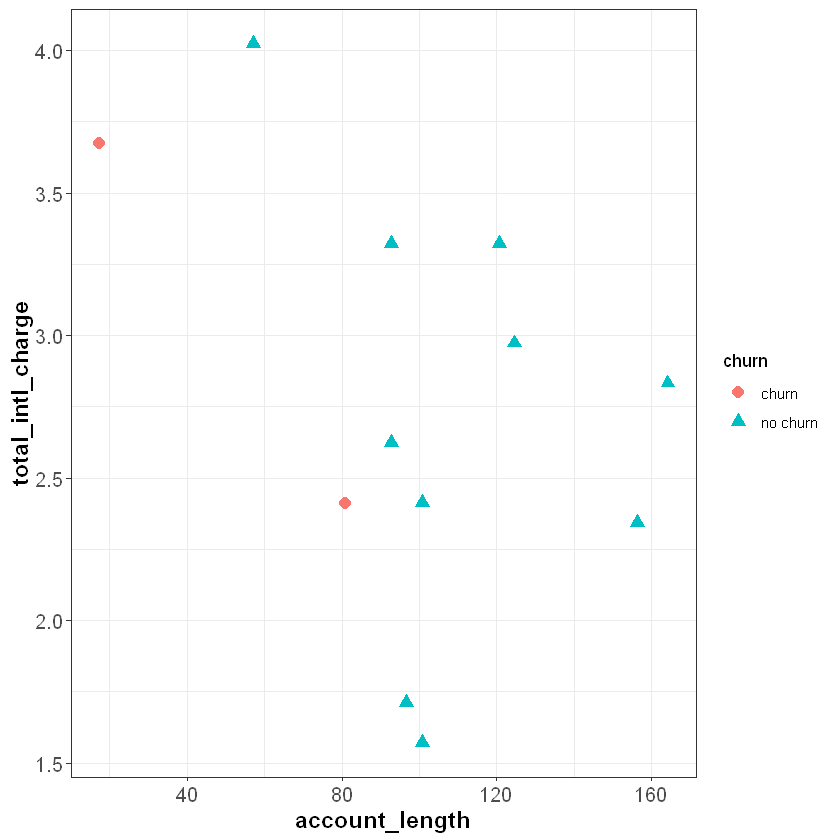

In [3]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)
library(ggplot2)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

The classification tree algorithm works by drawing a straight line that partitions the feature space to maximize the homogeneity (or minimize the entropy) of each sub-region. For example, imagine we drew a vertical line around `account_length` = 87, dividing the feature space into **R1** and **R2**. Intuitively, R2 is completely homogeneous because it only contains observations with the same outcome—"no churn". R1 is less homogeneous because it contains two "churn" observations and one "no churn" observation.

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


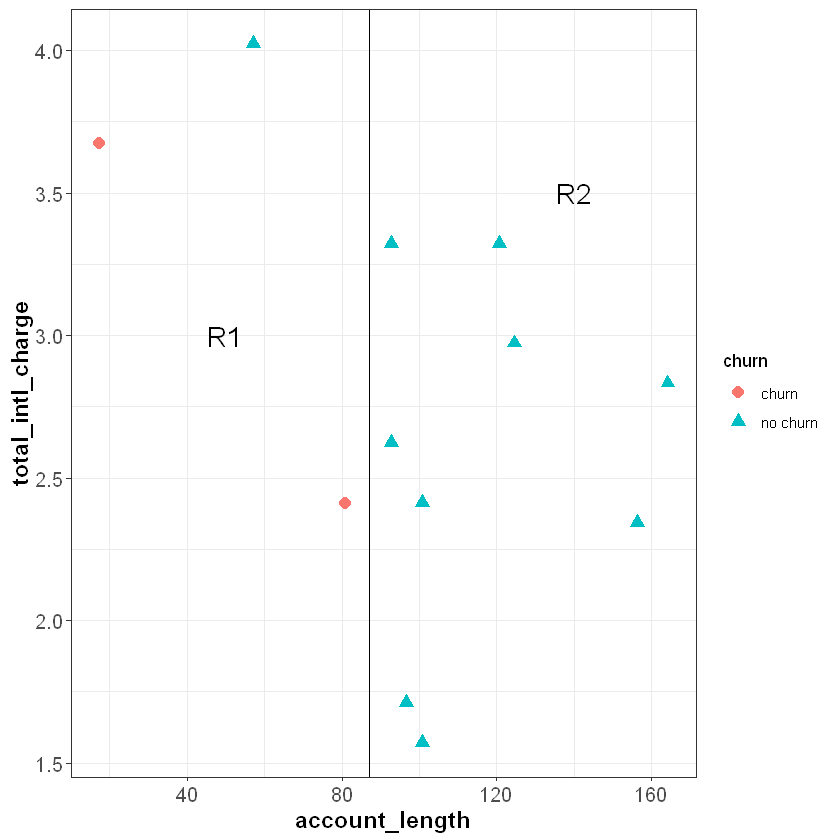

In [4]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
    geom_vline(xintercept = 87) + 
  annotate("text", x = 50, y = 3, label = "R1", size=6) + 
  annotate("text", x = 140, y = 3.5, label = "R2", size=6)

In this simple example we made cuts based on a visual inspection of the data, but the classification tree algorithm uses a measure known as **entropy** to ensure that each cut maximizes the homogeneity of the resulting sub-spaces. Entropy is defined as follows:

$$Entropy = -\sum_i^C{p_ilog(p_i)}$$

where the data set has $C$ classes (or unique outcome values), and $p_i$ represents the proportion of observations in the data from the $i$th class. In our case $C=2$ because we have two classes: "churn" and "no churn". Notice, this is very similar to the log loss formula that we introduced in [Log Loss](../09_model_eval/performance_metrics.html#log-loss). 

Using this formula, we can first calculate the entropy of our original data set (before we made any cuts), which we'll call $E_0$. There are two "churn" customers and ten "no churn" customers, so the entropy is:

$$E_0 = -[\frac{2}{12}log(\frac{2}{12}) + \frac{10}{12}log(\frac{10}{12})] = 0.1957$$

Now we will calculate the entropy after making the cut, for each subspace separately. The subspace **R2** is completely homogeneous (all nine customers are "no churn"), so the entropy equals zero:

$$E_{R2} = -[\frac{9}{9}log(\frac{9}{9})] = 0$$

The subspace $R1$ has one "no churn" and two "churns", so the entropy equals:

$$E_{R1} = -[\frac{2}{3}log(\frac{2}{3}) + \frac{1}{3}log(\frac{1}{3})] = 0.2764$$

To calculate the overall entropy after making the cut at `account_length` = 87, we take a weighted average of $E_{R1}$ and $E_{R2}$ based on the number of observations in each subspace:

$$E_{Cut1} = \frac{3}{12}E_{R1} + \frac{9}{12}E_{R2} = 0.0691$$

The **information gain**, or the reduction in entropy due to this cut, is then:
$$E_0 - E_{Cut1} = 0.1957 - 0.0691 = 0.1266$$ 

Each cut is made at the point that will result in the greatest reduction in the information gain. To further reduce the entropy of **R1**, we can make a cut around `total_intl_charge` = 3.8 to partition **R1** into two smaller regions (**R3** and **R4**) that are completely homogeneous. Because the feature space is completely divided into pure regions, the entropy after the second cut is zero:

$$\begin{aligned}E_{Cut2} & = \frac{9}{12}E_{R2} + \frac{2}{12}E_{R3} + \frac{1}{12}E_{R4} \\ & = \frac{9}{12}(0) + \frac{2}{12}(0) + \frac{1}{12}(0) \\ & = 0
\end{aligned}$$

Parsed with column specification:
cols(
  account_length = col_double(),
  total_intl_charge = col_double(),
  churn = col_double()
)


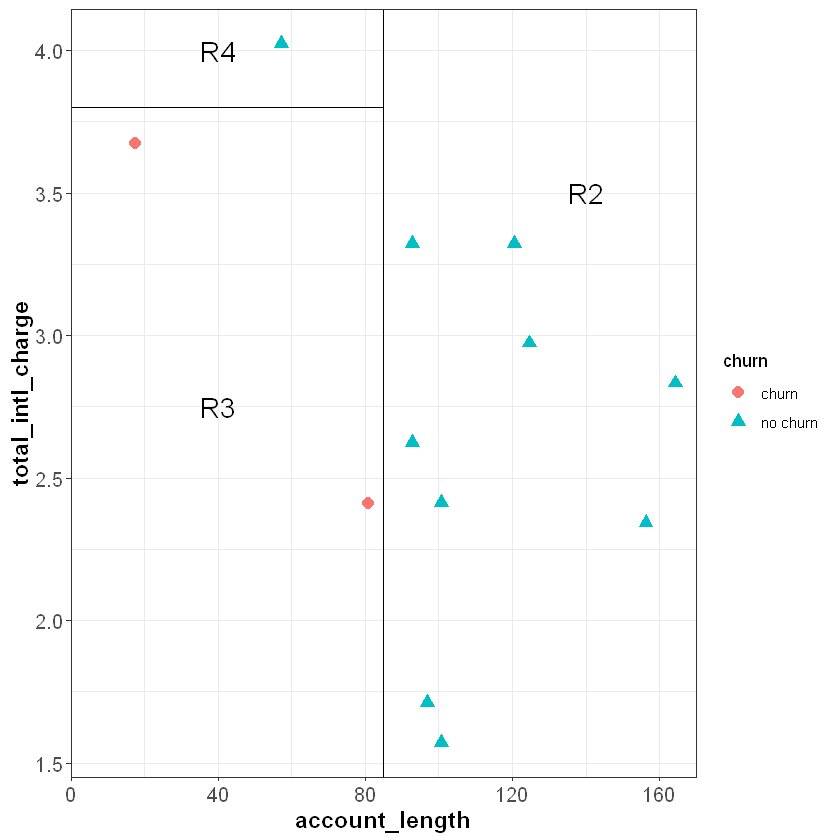

In [5]:
churnSample <- read_csv("../_build/data/churn_sample2.csv")
churnSample$churn = ifelse(churnSample$churn==1, "churn", "no churn")
churnSample$account_length = churnSample$account_length*sd(churn$account_length) + mean(churn$account_length)
churnSample$total_intl_charge = churnSample$total_intl_charge*sd(churn$total_intl_charge) + mean(churn$total_intl_charge)

ggplot(churnSample, aes(x=account_length, y=total_intl_charge, color=churn, shape=churn)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
    geom_vline(xintercept = 85) + 
  annotate("text", x = 140, y = 3.5, label = "R2", size=6) + 
  annotate("text", x = 40, y = 4, label = "R4", size=6) + 
  annotate("text", x = 40, y = 2.75, label = "R3", size=6) + 
  geom_segment(aes(x = 0, y = 3.8, xend = 85, yend = 3.8), color="black") +
  scale_x_continuous(limits = c(0, 170), expand = c(0, 0))
  

Because each subspace is completely pure, there are no additional cuts we could make to further reduce the entropy. 

To create pure feature space, we first made a cut at `account_length` = 87, then within the region where `account_length` was less than 87 made an additional cut at `total_intl_charge` = 3.8.  From this we can write out a set of decision rules:

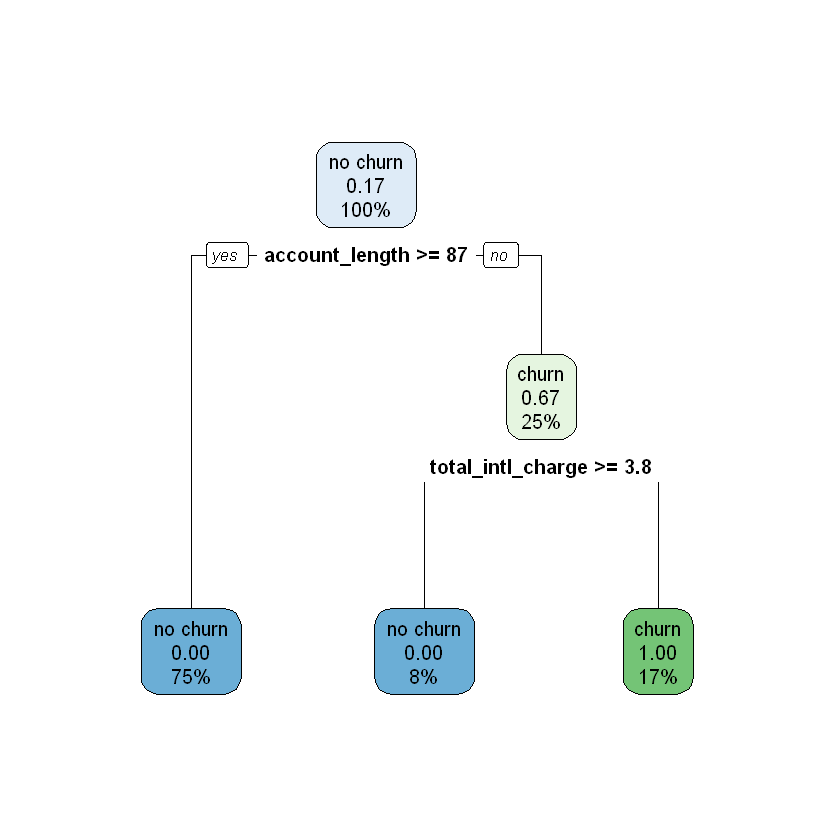

In [6]:
thing <- churnSample
thing$churn <- factor(thing$churn, levels=c("churn", "no churn"))
thing$churn <- ordered(thing$churn, levels = c("no churn", "churn"))
modelDT1 <- rpart(churn ~ ., data = thing, minsplit = 1)
rpart.plot(modelDT1)

We can use this decision tree to predict whether or not a new observation will churn. For example:

+ If a new observation has an `account_length` greater than or equal to 87, we move down the left branch of the tree and predict "no churn". 
+ If a new observation has an `account_length` less than 87 and a `total_intl_charge` greater than or equal to 3.8, we would move right at the first split and left at the second split of the tree, leading to a prediction of "no churn". 
+ If a new observation has an `account_length` less than 87 and a `total_intl_charge` less than 3.8, we would move right at the first split and right at the second split of the tree, leading to a prediction of "churn".

How do we interpret the numbers shown in the tree? In the plot each node has three rows, showing (in order):

+ The majority class in that node ("churn" / "no churn").
+ The proportion of the observations in that node that churned.
+ The percentage of the total data inside that node.

For example, let's start at the top node, which represents the data set before any cuts have been made. Because no cuts have been made, this node includes all of the data, so the third line shows 100%. Of the twelve observations in the data set, two of them churned, so the proportion of observations that churned equals (2 / 12) $\approx$ 0.17. Because this proportion is lower than the default cutoff of 0.5, the majority class for this node is "no churn". 

Now imagine what happens as we work our way down the tree. If `account_length` is greater than or equal to 87 we move to the left branch. This corresponds to the subspace R2 in the plot of the feature space. This subspace contains nine observations, or 75% of the total observations in the data set ((9 / 12) = 75%). None of these observations churned, so the second line in the node is 0.00, and the majority class is "no churn". 

Now imagine we work our way down the right branch of the tree. If `account_length` is less than 87, we move into the subspace R1. R1 has three observations ((3 / 12) = 25%), two of which churned ((2 / 3) $\approx$ 0.67). From this node, if `total_intl_charge` is less than 3.8 we move to the right, which represents subspace R3. Here we have two observations ((2 / 12) $\approx$ 17%), both of which churned ((2 / 2) = 1.00). If instead `total_intl_charge` is greater than or equal to 3.8 we move to the left, which represents subspace R4. Here we have one observation ((1 / 12) $\approx$ 8%), which did not churn ((0 / 1) = 0.00).

In R, we can fit a classification tree to our data using the `rpart()` function from the `rpart` package. This function uses the following syntax:

```{admonition} Syntax
`rpart::rpart(y ~ x1 + x2 + ... + xp, data, maxdepth = 30)`
+ *Required arguments*
  - `y`: The name of the dependent ($Y$) variable.
  - `x1`, `x2`, ... `xp`: The name of the first, second, and $pth$ independent variables.
  - `data`: The name of the data frame with the `y`, `x1`, `x2`, and `xp` variables.
+ *Optional arguments*
  - `maxdepth`: The maximum depth of the tree (see [Tuning Hyperparameters](decision_trees.html#tuning-hyperparameters) below).
```

Then, after we have built a model with `rpart()`, we can visualize the tree with the `rpart.plot()` function from the `rpart.plot` package:

```{admonition} Syntax
`rpart.plot::rpart.plot(x)`
+ *Required arguments*
  - `x`: A tree model built with `rpart()`.
```

Below we apply these functions to our full `churn` data set:

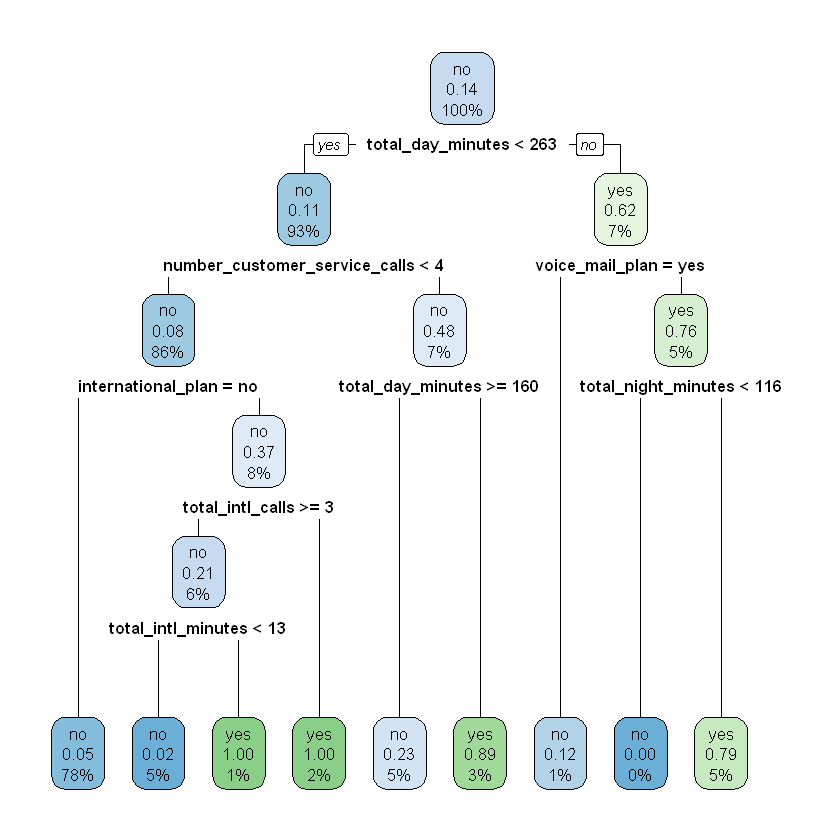

In [7]:
model <- rpart(churn ~ ., data = churn)
rpart.plot(model)

### Tuning Hyperparameters

Let's return to the simplified data set from the previous section, with only twelve observations and two features. After inspecting the classification tree we built from this data, you may suspect that something is wrong with the right branch - customers with a higher `total_intl_charge` are classified as "no churn", while customers with a lower `total_intl_charge` are classified as "churn". Based on the context of the business we may find this pattern surprising, as we expect customers with high international charges to be *more* likely to switch services. One possibility is that we are overfitting the data, so the decision tree is picking up on the noise in the sample instead of the signal.

To prevent overfitting, we can **prune** the decision tree to a certain depth; or, in other words, limit how many cuts we can perform. For example, let us prune this tree to a depth of one, meaning the algorithm cannot make more than one cut. The resulting pruned tree is shown below. Under this set of rules, customers with an `account_length` greater than or equal to 87 are classified as "no churn"; this is because subspace R2 (which represents `account_length` >= 87) contains only "no churn" observations. Customers with an `account_length` less than 87 are assigned a probability of churning of 0.67; this is because subspace R1 (which represents `account_length` < 87) contains two "churn" observations and one "no churn" observation ((2 / 3) $\approx$ 0.67).

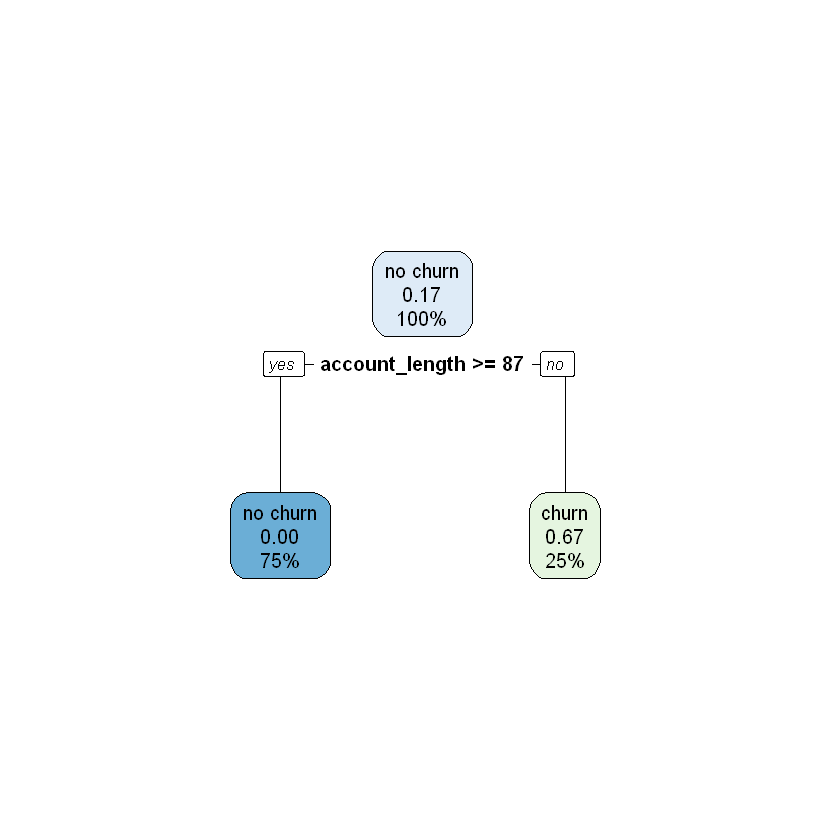

In [8]:
thing <- churnSample
thing$churn <- factor(thing$churn, levels=c("churn", "no churn"))
thing$churn <- ordered(thing$churn, levels = c("no churn", "churn"))
modelDT2 <- rpart(churn ~ ., data = thing, minsplit = 0, maxdepth=1)#
rpart.plot(modelDT2)

By tuning the value of the tree's depth, we seek to balance the bias-variance trade-off. The **bias-variance trade-off** refers to the tension between how closely a model fits its training data, versus how well it generalizes to unseen data. For the decision tree algorithm, the closest fit to the training data is achieved when the tree is not pruned at all and can grow unconstrained. The primary issue is that this fit is likely *too* close. When the pruning depth is too large, our tree will grow too deep and overfit the training data. Conversely, if the depth is too small, our tree will not grow deep enough and will underfit the training data. Therefore, we need a method to identify the value of depth that balances this trade-off in our data. This is covered in a subsequent section, [Model Evaluation](data_partition.html#k-fold-cross-validation). 

## (&sect;) Regression Trees

:::{note}
This section is optional, and will not be covered in the DSM course. For the assigned reading move on to section [10. Model Evaluation](../10_model_eval/model_eval.html#model-evaluation). 
:::

In the previous section, we saw how classification trees can be used to model binary outcomes. In this section, we will explore the other type of CART model, regression trees, which are similar but model continuous outcomes. We will apply the regression tree model to a housing price data set (source [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)), where the outcome variable is the most recent sales price of each home in the data set (`SalePrice`). There are over 70 additional variables in the data set, including the following:

+ `MSZoning`: the general zoning classification.
+ `LotFrontage`: linear feet of street connected to property.
+ `LotArea`: lot size in square feet.
+ `Street`: type of road access.
+ `Alley`: type of alley access.
+ `LotShape`: general shape of property.
+ `LandContour`: flatness of the property.
+ `Utilities`: type of utilities available.
+ `LotConfig`: lot configuration.
+ `LandSlope`: slope of property.
+ `GarageArea`: size of garage in square feet.

The data is stored in a data frame called `housing`:

In [9]:
head(housing)

MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour
1 60         RL       65           8450   Pave   NA    Reg      Lvl        
2 20         RL       80           9600   Pave   NA    Reg      Lvl        
3 70         RL       60           9550   Pave   NA    IR1      Lvl        
4 60         RL       84          14260   Pave   NA    IR1      Lvl        
5 50         RL       85          14115   Pave   NA    IR1      Lvl        
6 50         RM       51           6120   Pave   NA    Reg      Lvl        
  Utilities LotConfig ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold
1 AllPub    Inside    ... 0        NA     NA    NA            0      2    
2 AllPub    FR2       ... 0        NA     NA    NA            0      5    
3 AllPub    Corner    ... 0        NA     NA    NA            0      2    
4 AllPub    FR2       ... 0        NA     NA    NA            0     12    
5 AllPub    Inside    ... 0        NA     MnPrv Shed        700     10    
6 AllPub    Inside    ... 0        NA     NA    NA            0      4    
  YrSold SaleType SaleCondition SalePrice
1 2008   WD       Normal        208500   
2 2007   WD       Normal        181500   
3 2006   WD       Abnorml       140000   
4 2008   WD       Normal        250000   
5 2009   WD       Normal        143000   
6 2008   WD       Abnorml       129900

To understand regression trees, let's imagine we are working with the simplified data set below, which contains only twenty observations and two independent variables (`LotArea` and `GarageArea`).

Parsed with column specification:
cols(
  LotArea = col_double(),
  GarageArea = col_double()
)


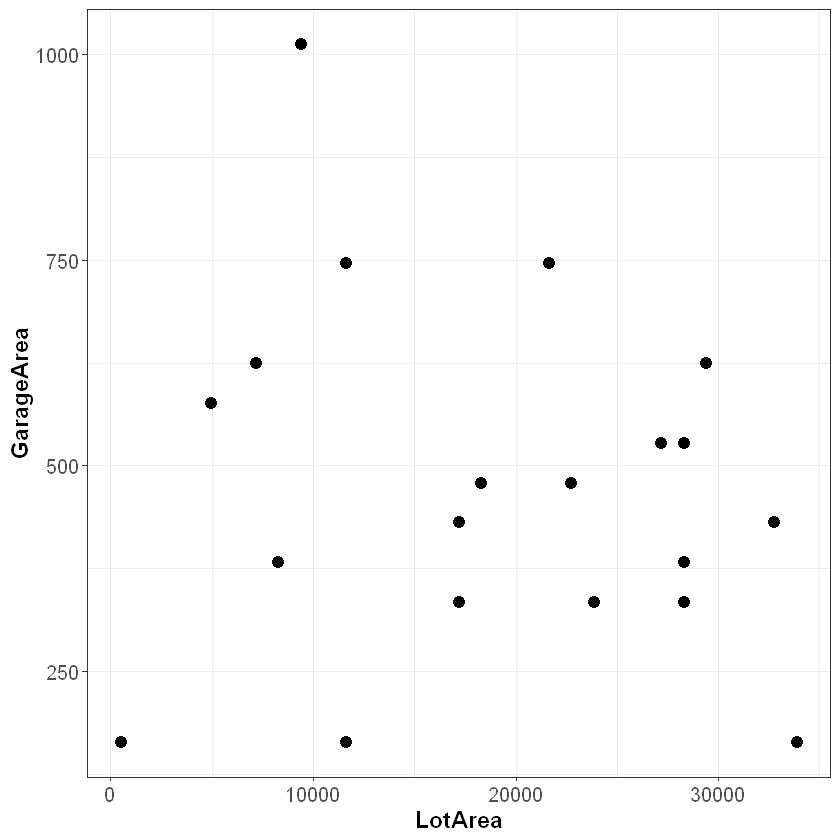

In [10]:
housingSample <- read_csv("../_build/data/housing_sample.csv")
library(ggplot2)

ggplot(housingSample, aes(x=LotArea, y=GarageArea)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

Similar to classification trees, regression trees are built by dividing this feature space into sub-spaces. Imagine we make a cut at `LotArea` = 15000, dividing the feature space into R1 and R2. We can already use this very simple model to predict `SalePrice` for new observations. If the `LotArea` of a new observation is greater than 15000, we predict the `SalePrice` value of that observation to be the average of the thirteen observations in R2. Similarly, if `LotArea` is less than 15000, we predict the average `SalePrice` of the seven observations in R1.

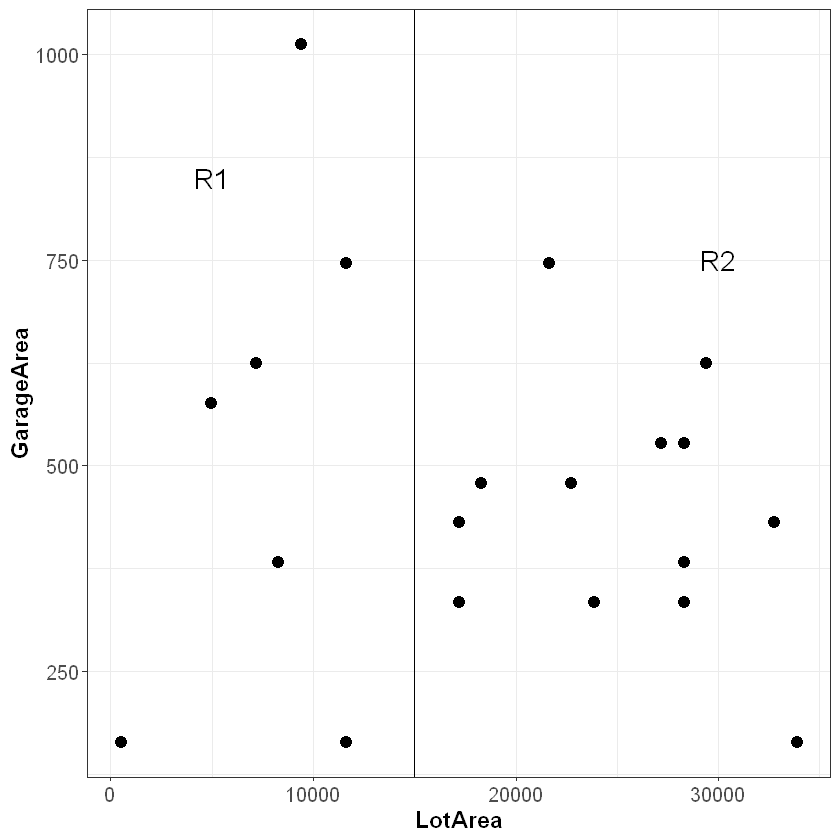

In [11]:
ggplot(housingSample, aes(x=LotArea, y=GarageArea)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) +
  geom_vline(xintercept = 15000) + 
  annotate("text", x = 5000, y = 850, label = "R1", size=6) + 
  annotate("text", x = 30000, y = 750, label = "R2", size=6)

How did we decide to make the first cut at `LotArea` = 15000? We will not show the full calculation here, but behind-the-scenes the algorithm chooses the cut that minimizes the error of the resulting model's predictions over all of the observations. More formally, the algorithm picks the cut that minimizes the **residual sum of squares (RSS)**: 

$$RSS = \sum_{i \in R1}(y_{i} - \hat{y_{R1}})^2 + \sum_{i \in R2}(y_{i} - \hat{y_{R2}})^2$$

where

+ $y_{i}$ is the observed realization of observation $i$; 
+ $\hat{y_{R1}}$ is the average of the realizations in R1 (*i.e.* the model's prediction for observations in R1)
+ $\hat{y_{R2}}$ is the average of the realizations in R2 (*i.e.* the model's prediction for observations in R2)

The first half of the formula represents the squared error of the observations in R1, and the second half represents the squared error of the observations in R2.

Now imagine performing the same procedure within R1 and R2. Within R1, let us say the cut that minimizes the RSS occurs at `LotArea` = 5500, dividing R1 into subsections R3 and R4. Within R2, suppose the cut that minimizes the RSS occurs at `GarageArea` = 375, dividing R2 into subsections R5 and R6. This would then divide our feature space further:

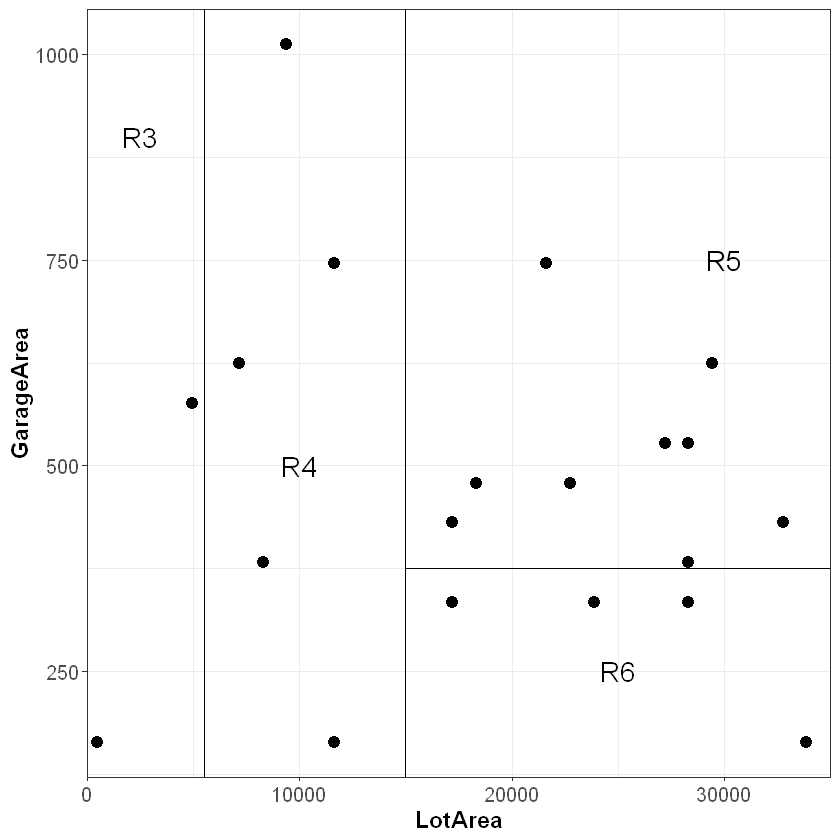

In [12]:
ggplot(housingSample, aes(x=LotArea, y=GarageArea)) + geom_point(size=3) + theme_bw() +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) +
  geom_vline(xintercept = 15000) + 
  geom_vline(xintercept = 5500) +
  annotate("text", x = 2500, y = 900, label = "R3", size=6) + 
  annotate("text", x = 10000, y = 500, label = "R4", size=6) +
  annotate("text", x = 30000, y = 750, label = "R5", size=6) +
  annotate("text", x = 30000, y = 750, label = "R5", size=6) +
  annotate("text", x = 25000, y = 250, label = "R6", size=6) +
  geom_segment(aes(x = 15000, y = 375, xend = 35000, yend = 375), color="black") +
  scale_x_continuous(limits = c(0, 35000), expand = c(0, 0))
  

If we wanted to, we could continue dividing our feature space until each observation was in its own rectangle. However, this would almost certainly result in overfitting, so we want to prune the tree to ensure it generalizes to our test set. Assuming we stop growing our tree here, this produces a set of logical rules that can be used to predict new observations:

```{figure} ../_build/html/_images/regression_tree.png
---
height: 400px
---
```

Each node in the tree indicates (i) the average value of the outcome (`SalePrice`) for all observations in the node, and (ii) the proportion of observations in the node. Say we wanted to predict `SalePrice` for a new observation in which `LotArea` = 20000 and `GarageArea` = 300. On the decision tree, we move to the right at the first split and to the left at the second split, leading to the third terminal node from the left. This node, which represents the subspace R6, contains 20% of the observations in our data set. The average `SalePrice` of these observations is \$185,000, so our prediction for the new observation would be \$185,000. 

We can fit the model to the full `housing` data set using the same `rpart()` function we saw in the previous section. Note that the `rpart()` function is able to recognize whether the outcome variable is discrete or continuous, so you do not need to specify this explicitly.

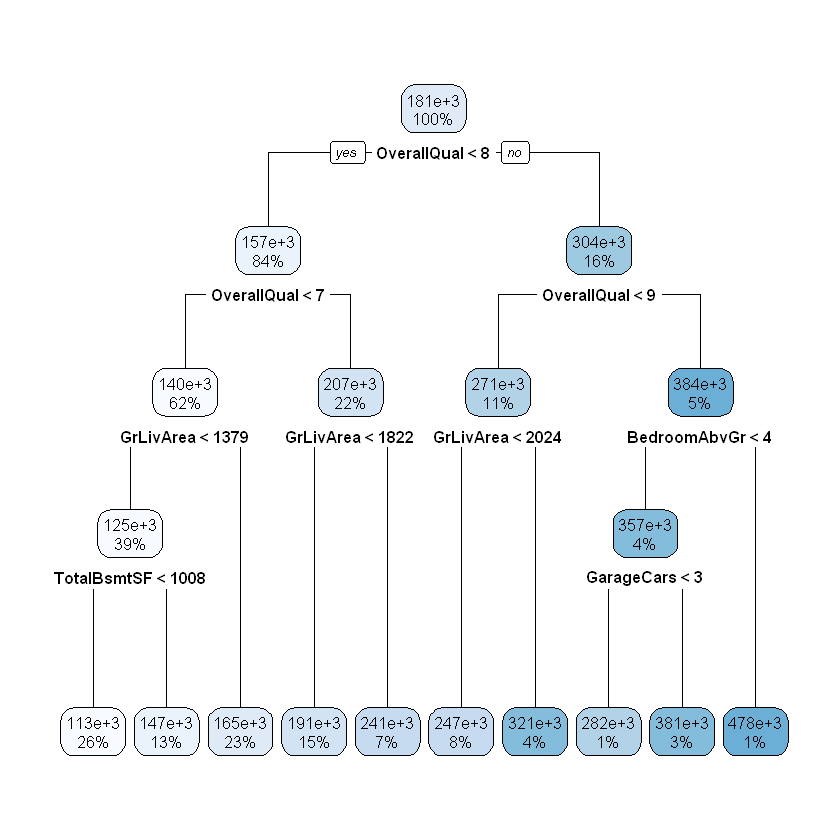

In [13]:
housingModel <- rpart(SalePrice ~ ., data = housing)
rpart.plot(housingModel)